## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [50]:
# Loading data
import json
import numpy as np
import pandas as pd

# Data visualization and EDA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS


# Text processing
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint


# Libraries for machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Libraries for evaluating models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from sklearn.decomposition import NMF


## 1. Data Loading

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file
f = open('complaints.json')

# Returns JSON object as a dictionary
data = json.load(f)

# Create dataframe from dictionary
df=pd.json_normalize(data)

In [3]:
# Inspect the dataframe to understand the given data.
df.head(5)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
# Shape of the dataframe
df.shape

(78313, 22)

Dataset has 78,313 customer complaints and 22 features. Customer complaint is in column _source.complaint_what_happened

In [5]:
# Print the column names
list(df.columns)


['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [6]:
# Assign new column names
new_column_mapping = {x: x[1:].replace('source.', '').replace('_what_happened', '') for x in df.columns}
df = df.rename(columns=new_column_mapping)
df.head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
# View column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

There are many columns with missing values. Score is the only numeric column.

In [8]:
# Inspect missing values
df.isna().sum(0)

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint                        0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

There are multiple columns with missing values. But we do not need them for model building. So will ignore.

In [9]:
# Assign nan in place of blanks in the complaints column
df['complaint'] = df['complaint'].apply(lambda x: np.nan if x == '' else x)
df['complaint'].isna().sum()

57241

In [10]:
# Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint'])
df.shape


(21072, 22)

## 2. Text Preprocessing

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [11]:
# Function to clean the text and remove all the unnecessary elements
def preprocess_text(text):

    # Lower case
    text = text.lower()

    # Pattern to match text inside square brackets
    pattern = r'\[.*?\]'
    text = re.sub(pattern, '', text)

    # Pattern to match punctuation
    pattern = r'[^\w\s]'
    text = re.sub(pattern, '', text)

    # Pattern to match numbers
    pattern = r'\w*\d\w*'
    text = re.sub(pattern, '', text)

    return text


In [12]:
# Function to Lemmatize the texts
def lemmatizer(text):

    # List to store lemmas
    sent = []

    # Extract lemmas of a given text and store in sent
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)

    return " ".join(sent)

In [13]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame(df['complaint'].apply(lambda x: preprocess_text(x)))
df_clean.head()

,complaint
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...


In [14]:
df_clean["complaint_lemma"] = df_clean.apply(lambda x: lemmatizer(x['complaint']), axis=1)
df_clean.head()

,complaint,complaint_lemma
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [15]:
# Function to extract the POS tags

def pos_tag(text):
    doc = nlp(text)
    sent = []
    
    for token in doc:
        if token.pos_ == 'NOUN':
            sent.append(token.text)
    return " ".join(sent)

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['complaint_lemma']), axis=1)


In [16]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,complaint_lemma,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...


In [17]:
df_clean.shape

(21072, 3)

## 3. Data Visualization - Exploratory Data Analysis

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




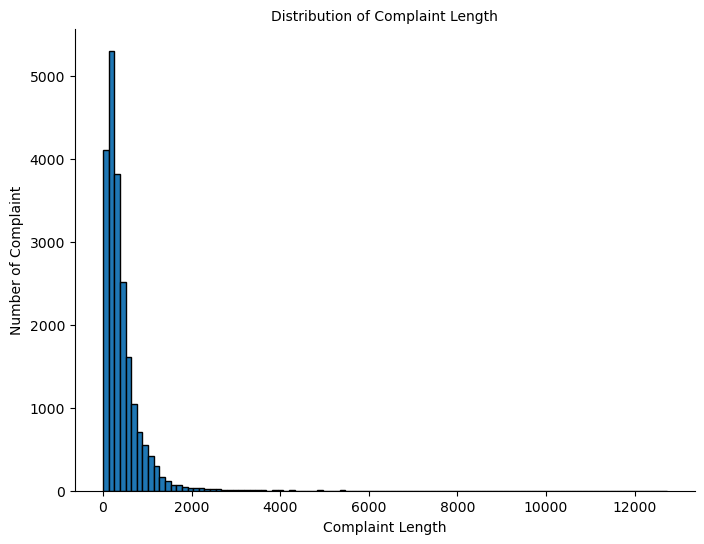

In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length
com_length = [len(d) for d in df_clean['complaint_POS_removed']]

# Plot data to visualize character length of complaints
plt.figure(figsize=(8,6))
plt.hist(com_length, edgecolor='black', bins = 100)
plt.title('Distribution of Complaint Length', fontsize=10)
plt.ylabel('Number of Complaint', fontsize=10)
plt.xlabel('Complaint Length', fontsize=10)
sns.despine()
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

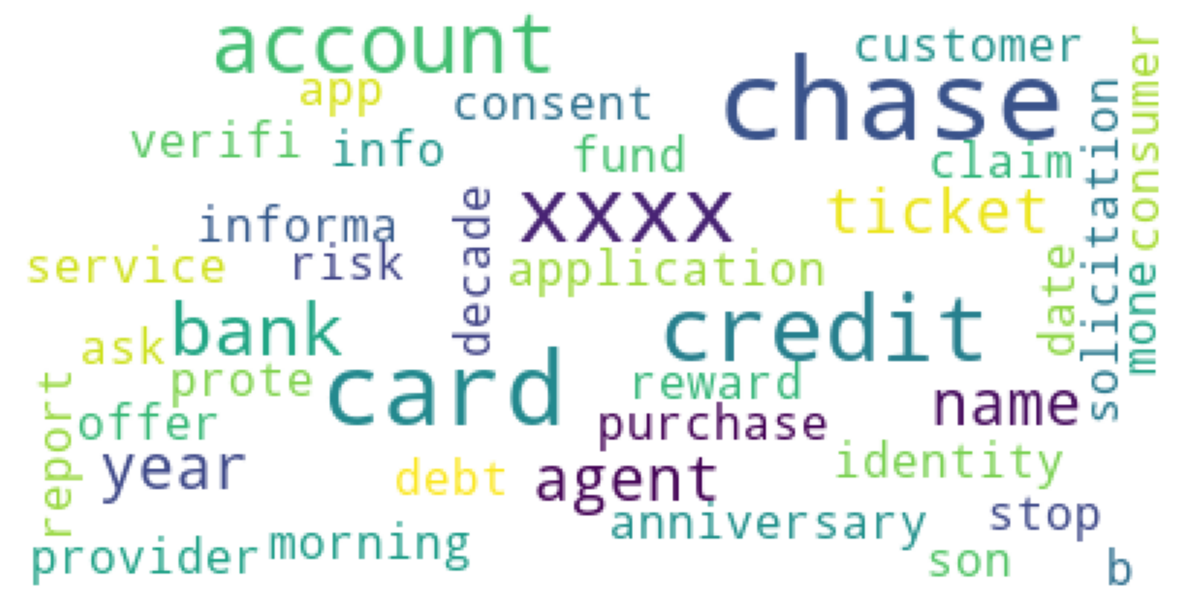

In [19]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=1
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [20]:
# Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [21]:
df_clean.shape

(21072, 4)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [22]:
# Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_words(data, n, ngram):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n] 

In [23]:
# Print the top 30 words in the unigram frequency
get_top_words(df_clean['Complaint_clean'].values.astype('U'), 30, 1)


[('chase', 52739),
 ('xxxx', 48287),
 ('account', 46731),
 ('credit', 33470),
 ('card', 30216),
 ('bank', 21612),
 ('payment', 21158),
 ('time', 16008),
 ('charge', 14152),
 ('xxxxxxxx', 13579),
 ('day', 12971),
 ('check', 12099),
 ('money', 11953),
 ('loan', 10899),
 ('information', 9644),
 ('letter', 9598),
 ('fee', 8890),
 ('report', 8855),
 ('number', 8614),
 ('transaction', 8564),
 ('month', 8461),
 ('year', 8289),
 ('customer', 8137),
 ('mortgage', 8072),
 ('balance', 7759),
 ('service', 7698),
 ('phone', 7570),
 ('company', 7534),
 ('claim', 7208),
 ('state', 7146)]

In [24]:
# Print the top 10 words in the bigram frequency
get_top_words(df_clean['Complaint_clean'].values.astype('U'), 10, 2)

[('credit card', 12850),
 ('xxxx xxxx', 5229),
 ('credit report', 3930),
 ('customer service', 3058),
 ('account chase', 2930),
 ('chase credit', 2822),
 ('chase account', 2597),
 ('bank account', 2440),
 ('check account', 2289),
 ('account account', 2249)]

In [25]:
# Print the top 10 words in the trigram frequency
get_top_words(df_clean['Complaint_clean'].values.astype('U'), 10, 3)

[('chase credit card', 1890),
 ('credit card account', 1088),
 ('credit card company', 988),
 ('xxxx xxxx xxxx', 842),
 ('xxxx credit card', 812),
 ('credit card chase', 710),
 ('credit card credit', 512),
 ('inquiry credit report', 489),
 ('credit card xxxx', 430),
 ('account credit card', 410)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [26]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [27]:
# All masked texts has been removed
df_clean

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


In [28]:
df_clean.shape

(21072, 4)

## 4. Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [29]:
# Write your code here to initialise the TfidfVectorizer

# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [30]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

# Create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix = tfidf.fit_transform(df_clean['Complaint_clean'])

## 5. Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [31]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state = 40
nmf_model = NMF(n_components=num_topics, init='random', random_state=40)

In [32]:
nmf_model.fit(doc_term_matrix)
feature_names = tfidf.get_feature_names_out()
len(feature_names)

6864

In [33]:
# Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'Top 15 words for TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')


Top 15 words for TOPIC #0
['time', 'service', 'application', 'offer', 'purchase', 'month', 'point', 'year', 'score', 'limit', 'account', 'balance', 'chase', 'credit', 'card']


Top 15 words for TOPIC #1
['letter', 'date', 'statement', 'balance', 'property', 'rate', 'year', 'time', 'modification', 'month', 'home', 'chase', 'mortgage', 'loan', 'payment']


Top 15 words for TOPIC #2
['day', 'company', 'time', 'refund', 'email', 'service', 'purchase', 'fraud', 'claim', 'merchant', 'fee', 'chase', 'transaction', 'dispute', 'charge']


Top 15 words for TOPIC #3
['customer', 'transaction', 'transfer', 'business', 'number', 'checking', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']


Top 15 words for TOPIC #4
['creditor', 'file', 'date', 'letter', 'score', 'theft', 'account', 'identity', 'debt', 'reporting', 'information', 'company', 'credit', 'inquiry', 'report']




In [34]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
def find_topic(data, tfidf, nmf_model):
    tfidf_vector = tfidf.transform([data])
    topic_id = nmf_model.transform(tfidf_vector).argmax()
    return topic_id


In [35]:
df_clean.shape

(21072, 4)

In [36]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = df_clean.apply(lambda x: find_topic(x['Complaint_clean'], tfidf, nmf_model), axis=1) #write your code to assign topics to each rows.

In [37]:
df_clean.head()

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,3
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,3
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,4
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,4
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,3


In [38]:
df_clean.shape

(21072, 5)

In [39]:
# Print the first 5 Complaint for each of the Topics
df_clean_temp=df_clean.groupby('Topic').head(5)
df_clean_temp.sort_values('Topic')

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
65,i opened the chasexxxx xxxx rewards credit car...,I open the chasexxxx xxxx reward credit card a...,chasexxxx xxxx reward credit card time offer x...,chase reward credit card time offer reward p...,0
64,chase is marketing credit cards to those of us...,chase be marketing credit card to those of we ...,chase credit card credit style marketing swa c...,chase credit card credit style marketing swa c...,0
59,i currently have over xxxx chase ultimate rewa...,I currently have over xxxx chase ultimate rewa...,chase reward point month reward account bonus ...,chase reward point month reward account bonus ...,0
50,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen scamme company time share company refu...,citizen scamme company time share company refu...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,chase card decline catering order place brothe...,0
81,i bought a new xxxx xxxx on xxxxxxxx from xxxx...,I buy a new xxxx xxxx on xxxxxxxx from xxxx xx...,xxxx loan title chase time resolution time sta...,loan title chase time resolution time state r...,1
58,i made a purchase of on xxxxxxxx i made payme...,I make a purchase of on xxxxxxxx I make paym...,purchase xxxxxxxx payment xxxxxxxx xxxxxxxx pa...,purchase payment payment closing date state...,1
57,i have been trying to do a loan modification w...,I have be try to do a loan modification with c...,loan modification chase payment doc,loan modification chase payment doc,1
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,1
73,i have wired through one of chase branches in ...,I have wire through one of chase branch in xxx...,wire chase branch reinstatement amount order f...,wire chase branch reinstatement amount order f...,1


In [40]:
df_clean.shape

(21072, 5)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [41]:
#Create the dictionary of Topic names and Topics

Topic_names = {0: "Credit card or prepaid card",
              1: "Mortgage/Loan",
              2: "Bank Account services",
              3: "Bank Account services",
              4: "Theft/Dispute Reporting"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [42]:
df_clean

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,Bank Account services
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,chase card report application identity consent...,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,Bank Account services
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...,Mortgage/Loan


## 6. Supervised Model Building

Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [43]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['Complaint_clean', 'Topic']].copy()

In [44]:
training_data

,Complaint_clean,Topic
1,morning name stop bank service ask debt verifi...,Bank Account services
2,card agent anniversary date agent information...,Bank Account services
10,chase card report application identity consent...,Theft/Dispute Reporting
11,ticket offer ticket reward card information ...,Theft/Dispute Reporting
14,son chase account fund chase bank account mone...,Bank Account services
...,...,...
78303,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,credit card provider claim purchase protectio...,Bank Account services
78310,risk consumer chase bank app chase year banki...,Theft/Dispute Reporting
78311,credit yrs chase credit card chase freedom pro...,Mortgage/Loan


In [45]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [46]:
# Write your code to get the Vector count
count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 3), max_df=0.95, min_df=2, max_features=5000)
X_train_counts = count_vect.fit_transform(training_data['Complaint_clean'])
X_train_counts.shape

(21072, 5000)

In [47]:
# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()

X_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_tfidf.shape

(21072, 5000)

In [48]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, training_data['Topic'], 
                                                    test_size = 0.25,
                                                    random_state = 42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (15804, 5000)
Shape of y_train: (15804,)
Shape of X_test: (5268, 5000)
Shape of y_test: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Model 1 :: Logistic Regression

In [51]:
# Logistic Regression Model
lr_model = LogisticRegression(solver='liblinear')
%time 
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 5.96 μs


In [52]:
# Calculate F1 score
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
f1_lr

0.940567973527985

### Model 2 :: Decision Tree

In [53]:
dt_model = DecisionTreeClassifier()
%time 
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 8.11 μs


In [54]:
# Calculate F1 score
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.8637223741198297

### Model 3 :: Random Forest

In [55]:
# Random Forest Model
rf_model = RandomForestClassifier()
%time 
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 6.91 μs


In [56]:
# Calculate F1 score
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.9170714994700229

### Model 4 :: Naive Bayes

In [57]:
# Naive Bayes Model
nb_model = MultinomialNB()
%time 
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.81 μs


In [58]:
# Calculate F1 score
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.8669049146182286

## 7. Model Inference

In [59]:
dummy_text = 'I want to take home loan for amount $200,000.'
dummy_text = lemmatizer(dummy_text)
dummy_text = pos_tag(dummy_text)
dummy_text_vec = count_vect.transform([dummy_text])
dummy_text_vec = tfidf_transformer.transform(dummy_text_vec)
pred = lr_model.predict(dummy_text_vec)
print(f"Predicted Class: {pred[0]}")

Predicted Class: Mortgage/Loan
